# Tutorial with LSST after Delight tutorial run from RAIL

We will use the parameter file "tests/parametersTest.cfg".
This contains a description of the bands and data to be used.
In this example we will generate mock data for the ugrizy LSST bands,
**fit each object with our GP using ugi bands only and see how it predicts the rz bands.**
This is an example for filling in/predicting missing bands in a fully bayesian way
with a flexible SED model quickly via our photo-z GP.

In [1]:
!ls -l 

total 500
drwxr-xr-x 5 ubuntu ubuntu    160 Mar  3 16:07 data
-rw-r--r-- 1 ubuntu ubuntu  82034 Mar  3 09:23 delight_checkfitfilters.ipynb
-rw-r--r-- 1 ubuntu ubuntu 335355 Mar  3 09:23 delight_filters.ipynb
-rw-r--r-- 1 ubuntu ubuntu  18886 Mar  4 10:40 delight_lsst_tutorial_fromrail.ipynb
-rw-r--r-- 1 ubuntu ubuntu  68272 Feb 25 15:47 delight_sed.ipynb
drwxr-xr-x 4 ubuntu ubuntu    128 Mar  4 10:45 tmp


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

In [3]:
! ls tmp

delight_data  parametersTest.cfg


In [4]:
cat tmp/parametersTest.cfg



[Bands]
names: lsst_u lsst_g lsst_r lsst_i lsst_z lsst_y
directory: /home/ubuntu/.local/lib/python3.8/site-packages/delight/../data/FILTERS
numCoefs: 15
bands_verbose: True
bands_debug: True
bands_makeplots: False

[Templates]
directory: /home/ubuntu/.local/lib/python3.8/site-packages/delight/../data/CWW_SEDs
names: El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
p_t: 0.27 0.26 0.25 0.069 0.021 0.11 0.0061 0.0079
p_z_t:0.23 0.39 0.33 0.31 1.1 0.34 1.2 0.14
lambdaRef: 4.5e3

[Simulation]
numObjects: 1000
noiseLevel: 0.03
trainingFile: ./tmp/delight_data/galaxies-fluxredshifts.txt
targetFile: ./tmp/delight_data/galaxies-fluxredshifts2.txt
[Training]
catFile: ./tmp/delight_data/galaxies-fluxredshifts.txt
bandOrder: lsst_u lsst_u_var lsst_g lsst_g_var _ _ lsst_i lsst_i_var lsst_z lsst_z_var lsst_y lsst_y_var redshift
referenceBand: lsst_i
extraFracFluxError: 1e-4
paramFile: ./tmp/delight_data/galaxies-gpparams.txt
crossValidate: False
CVfile: 

## Analyze the outputs

In [5]:
# First read a bunch of useful stuff from the parameter file.
params = parseParamFile('tmp/parametersTest.cfg', verbose=False)

# bands
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms = readBandCoefficients(params)
bandNames = params['bandNames']
print('bandNames:',bandNames)
numBands, numCoefs = bandCoefAmplitudes.shape

# fluxes and redshift
fluxredshifts = np.loadtxt(params['target_catFile'])
print('target_catFile:',params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])
print('training_catFile:',params['training_catFile'])
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn, refBandColumn = readColumnPositions(params, prefix='target_')

# redshift
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
dir_seds = params['templates_directory']
print('templates_directory:',params['templates_directory'])

# filters
dir_filters = params['bands_directory']
print('bands_directory:',params['bands_directory'])
lambdaRef = params['lambdaRef']

#sed
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

bandNames: ['lsst_u', 'lsst_g', 'lsst_r', 'lsst_i', 'lsst_z', 'lsst_y']
target_catFile: ./tmp/delight_data/galaxies-fluxredshifts2.txt
training_catFile: ./tmp/delight_data/galaxies-fluxredshifts.txt
templates_directory: /home/ubuntu/.local/lib/python3.8/site-packages/delight/../data/CWW_SEDs
bands_directory: /home/ubuntu/.local/lib/python3.8/site-packages/delight/../data/FILTERS


In [6]:
lambdaRef

4500.0

In [7]:
redshiftDistGrid

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. ])

In [8]:
redshiftGrid

array([0.1  , 0.101, 0.102, ..., 3.098, 3.099, 3.1  ])

In [9]:
len(redshiftGrid)

3001

In [10]:
redshiftGridGP

array([0.1       , 0.10115859, 0.1023306 , 0.10351619, 0.10471551,
       0.10592873, 0.10715601, 0.1083975 , 0.10965338, 0.11092381,
       0.11220896, 0.113509  , 0.1148241 , 0.11615443, 0.11750018,
       0.11886152, 0.12023864, 0.12163171, 0.12304092, 0.12446645,
       0.1259085 , 0.12736726, 0.12884292, 0.13033568, 0.13184573,
       0.13337328, 0.13491852, 0.13648167, 0.13806293, 0.13966251,
       0.14128062, 0.14291748, 0.1445733 , 0.14624831, 0.14794272,
       0.14965677, 0.15139067, 0.15314466, 0.15491897, 0.15671384,
       0.15852951, 0.16036621, 0.16222419, 0.1641037 , 0.16600499,
       0.1679283 , 0.16987389, 0.17184203, 0.17383297, 0.17584697,
       0.17788431, 0.17994526, 0.18203008, 0.18413905, 0.18627246,
       0.18843059, 0.19061372, 0.19282215, 0.19505616, 0.19731606,
       0.19960213, 0.2019147 , 0.20425405, 0.20662051, 0.20901439,
       0.211436  , 0.21388567, 0.21636372, 0.21887049, 0.22140629,
       0.22397147, 0.22656638, 0.22919135, 0.23184673, 0.23453

In [11]:
len(redshiftGridGP)

300

In [12]:
f_mod.shape

(3001, 8, 6)

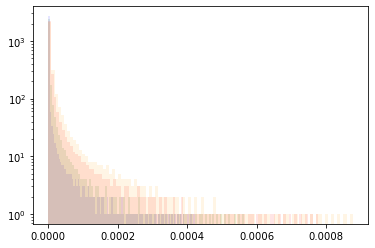

In [13]:
plt.hist(f_mod[:,0,0],facecolor="b",bins=100,alpha=0.1)
plt.hist(f_mod[:,1,0],facecolor="g",bins=100,alpha=0.1)
plt.hist(f_mod[:,2,0],facecolor="r",bins=100,alpha=0.1)
plt.hist(f_mod[:,3,0],facecolor="orange",bins=100,alpha=0.1)
plt.yscale('log')

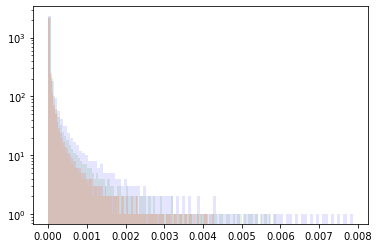

In [14]:
plt.hist(f_mod[:,0,5],facecolor="b",bins=100,alpha=0.1)
plt.hist(f_mod[:,1,5],facecolor="g",bins=100,alpha=0.1)
plt.hist(f_mod[:,2,5],facecolor="r",bins=100,alpha=0.1)
plt.hist(f_mod[:,3,5],facecolor="orange",bins=100,alpha=0.1)
plt.yscale('log')

In [15]:
# Load the PDF files
metricscww = np.loadtxt(params['metricsFile'])
metrics = np.loadtxt(params['metricsFileTemp'])
# Those of the indices of the true, mean, stdev, map, and map_std redshifts.
i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
i_ze = i_zm
i_std_ze = i_std_zm

pdfs = np.loadtxt(params['redshiftpdfFile'])
pdfs_cww = np.loadtxt(params['redshiftpdfFileTemp'])
pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
nobj = pdfatZ.size
#pdfs /= pdfs.max(axis=1)[:, None]
#pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

In [16]:
pdfs.shape

(1000, 3001)

In [17]:
pdfs_cww.shape

(1000, 3001)

In [18]:
nobj

1000

58 763 10 101 934 793 638 673 591 945 388 306 295 824 543 629 962 628 267 139 

<ipython-input-25-2df1baa9d27c>:24: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


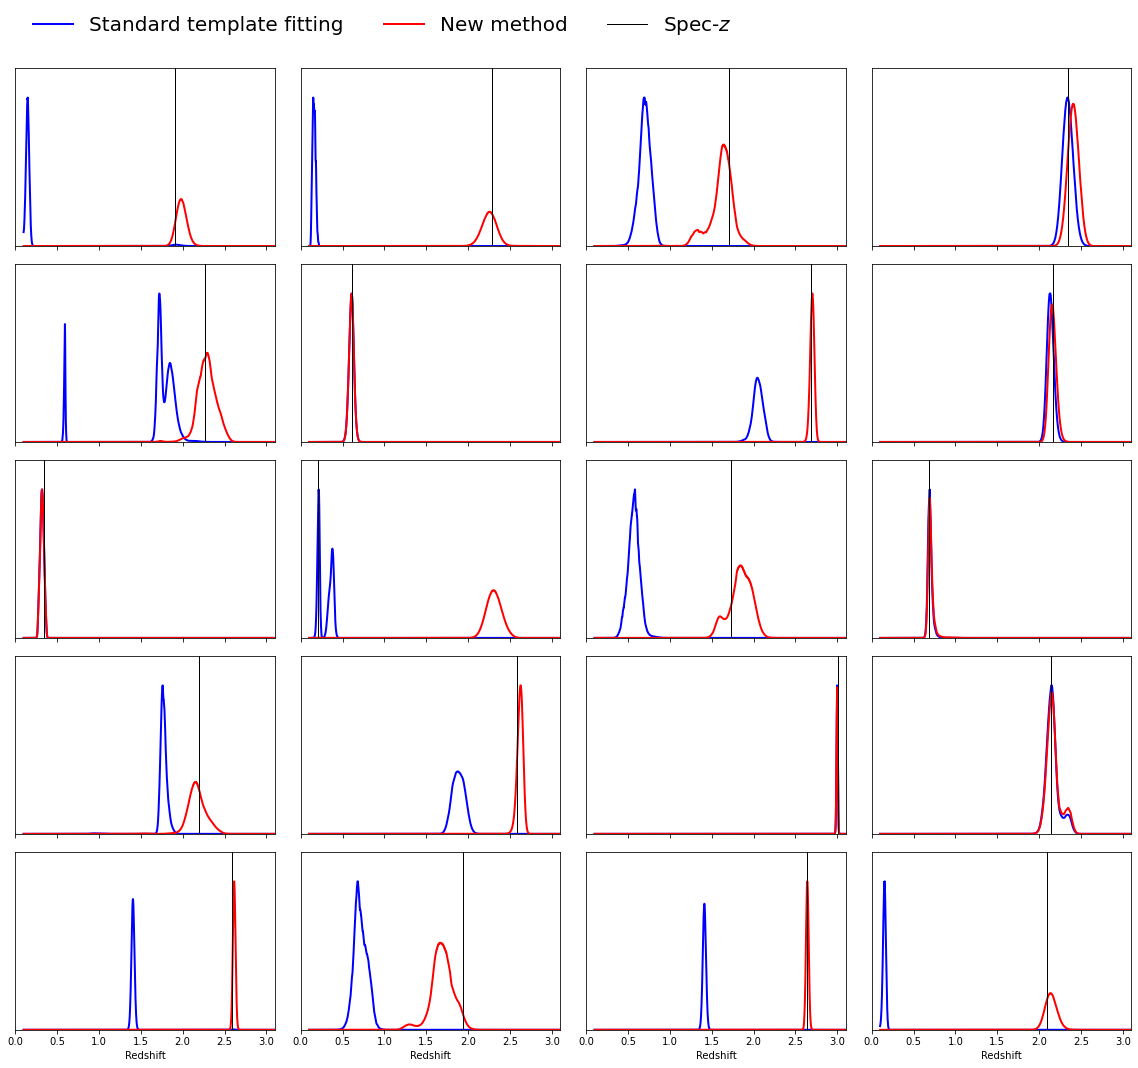

In [25]:
ncol = 4
fig, axs = plt.subplots(5, ncol, figsize=(20, 16), sharex=True, sharey=False)
axs = axs.ravel()
z = fluxredshifts[:, redshiftColumn]
sel = np.random.choice(nobj, axs.size, replace=False)
lw = 2

for ik in range(axs.size):
    k = sel[ik]
    print(k, end=" ")
    axs[ik].plot(redshiftGrid, pdfs_cww[k, :],color="b",lw=lw, label='Standard template fitting')# c="#2ecc71", 
    axs[ik].plot(redshiftGrid, pdfs[k, :],color="r" ,lw=lw, label='New method')  #, c="#3498db"
    axs[ik].axvline(fluxredshifts[k, redshiftColumn], c="k", lw=1, label=r'Spec-$z$')
    ymax = np.max(np.concatenate((pdfs[k, :], pdfs_cww[k, :])))
    axs[ik].set_ylim([0, ymax*1.2])
    axs[ik].set_xlim([0, 3.1])
    axs[ik].set_yticks([])
    axs[ik].set_xticks([0.0, 0.5,1,1.5,2.,2.5,3])

for i in range(ncol):
    axs[-i-1].set_xlabel('Redshift', fontsize=10)

axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4),fontsize=20)
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.96)


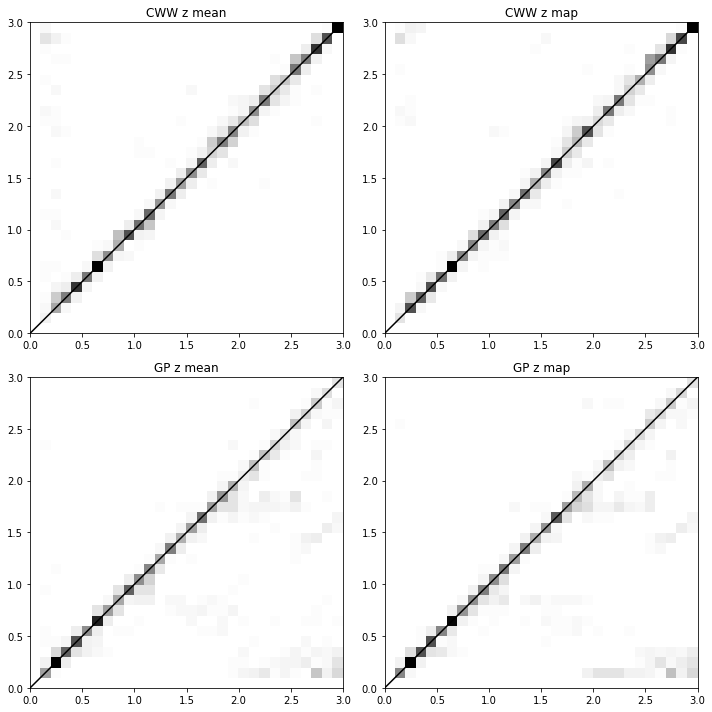

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
zmax = 3
rr = [[0, zmax], [0, zmax]]
nbins = 30
h = axs[0, 0].hist2d(metricscww[:, i_zt], metricscww[:, i_zm], nbins, cmap='Greys', range=rr)
hmin, hmax = np.min(h[0]), np.max(h[0])
axs[0, 0].set_title('CWW z mean')
axs[0, 1].hist2d(metricscww[:, i_zt], metricscww[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[0, 1].set_title('CWW z map')
axs[1, 0].hist2d(metrics[:, i_zt], metrics[:, i_zm], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 0].set_title('GP z mean')
axs[1, 1].hist2d(metrics[:, i_zt], metrics[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 1].set_title('GP z map')
axs[0, 0].plot([0, zmax], [0, zmax], c='k')
axs[0, 1].plot([0, zmax], [0, zmax], c='k')
axs[1, 0].plot([0, zmax], [0, zmax], c='k')
axs[1, 1].plot([0, zmax], [0, zmax], c='k')
fig.tight_layout()

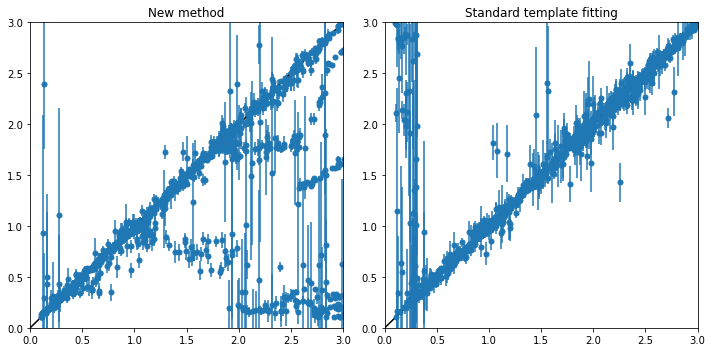

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
chi2s = ((metrics[:, i_zt] - metrics[:, i_ze])/metrics[:, i_std_ze])**2

axs[0].errorbar(metrics[:, i_zt], metrics[:, i_ze], yerr=metrics[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[1].errorbar(metricscww[:, i_zt], metricscww[:, i_ze], yerr=metricscww[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[0].plot([0, zmax], [0, zmax], 'k')
axs[1].plot([0, zmax], [0, zmax], 'k')
axs[0].set_xlim([0, zmax])
axs[1].set_xlim([0, zmax])
axs[0].set_ylim([0, zmax])
axs[1].set_ylim([0, zmax])
axs[0].set_title('New method')
axs[1].set_title('Standard template fitting')

fig.tight_layout()

Text(0.5, 1.0, 'New method')

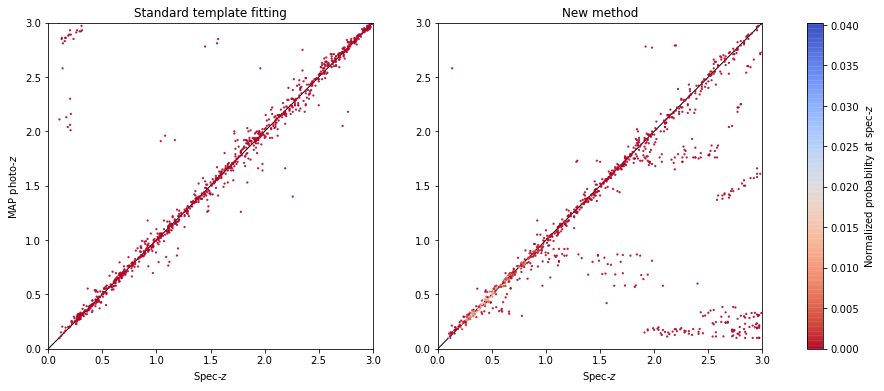

In [28]:
cmap = "coolwarm_r"
vmin = 0.0
alpha = 0.9
s = 5
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
vs = axs[0].scatter(metricscww[:, i_zt], metricscww[:, i_zmap], 
                    s=s, c=pdfatZ_cww, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[1].scatter(metrics[:, i_zt], metrics[:, i_zmap], 
                    s=s, c=pdfatZ, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Normalized probability at spec-$z$')
for i in range(2):
    axs[i].plot([0, zmax], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].set_ylim([0, zmax])
    axs[i].set_xlim([0, zmax])
    axs[i].set_xlabel('Spec-$z$')
axs[0].set_ylabel('MAP photo-$z$')

axs[0].set_title('Standard template fitting')
axs[1].set_title('New method')

## Conclusion
Don't be too harsh with the results of the standard template fitting or the new methods since both have a lot of parameters which can be optimized!

If the results above made sense, i.e. the redshifts are reasonnable for both methods on the mock data, then you can start modifying the parameter files and creating catalog files containing actual data! I recommend using less than 20k galaxies for training, and 1000 or 10k galaxies for the delight-apply script at the moment. Future updates will address this issue.